<a href="https://colab.research.google.com/github/gabrielrflopes/Estudos/blob/main/IBM_ML0101EN_KNN_Classification_Telecom_Services.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM ML0101EN - Classificação

**Este projeto consiste no laboratório realizado para o curso IBM ML0101EN, e tem o propósito de aplicação dos conteúdos aprendidos.**

Em Machine Learning, classificação é um tipo de aprendizado supervisionado em que se busca rotular novos exemplos em diferentes classes da variável-alvo, que neste caso assume valores discretos. Os modelos de classificação podem lidars com problemas que envolvem alvos binários ou multi-classes, como previsão de risco de crédito, previsão de rotatividade, filtragem de e-mails, reconhecimento de fala, classificação de documentos, previsão de receita de remédios, etc.

Neste projeto, iremos trabalhar com um conjunto de dados de uma empresa de telecomunicações que deseja construir um classificador para prever qual serviço é o mais provável de um novo cliente contratar, baseado nos dados históricos e demográficos disponíveis.

### Importando as Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Importando os Dados

In [ ]:
data_path = 'https://raw.githubusercontent.com/gabrielrflopes/Estudos/main/datasets/teleCust1000t.csv'

df = pd.read_csv(data_path)

df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


Imagine que uma empresa de telecomunicações segmentou seus clientes com base nos padrões de uso dos serviços, categorizando os clientes em 4 grupos. Se os dados demográficos podem ser usados para prever o grupo de serviços contratado pelos clientes, a empresa pode providenciar ofertas customizadas para prospectar um tipo específico de consumidor.

É um problema de classificação, visto que é preciso construir um modelo capaz de prever, para um novo exemplo, qual serviço é mais compatível com o consumidor, utilizando-se para isso um conjunto de dados históricos rotulados.

### Dicionário de Variáveis

- `Region`- Região em que se encontra o cliente;
- `tenure` - Tempo de permanência na empresa;
- `age`- Idade do cliente;
- `marital` - Se determinado cliente é casado ou não;
- `adress`- Endereço do cliente;
- `income` - Salário do cliente;
- `ed` - Grau de educação do cliente;
- `employ` - Tempo (em meses) que determinado cliente está empregado;
- `retire` - Se determinado cliente é aposentado ou não;
- `gender` - Gênero do cliente;
- `custcat`- Tipo de serviço contratado.

## Análise Exploratória

- **Dimensões do Dataset**

In [ ]:
print(f'Entradas:\t {df.shape[0]}',
      f'\nVariáveis:\t {df.shape[1]}')

Entradas:	 1000 
Variáveis:	 12


- **Tipos das variáveis**

O conjunto de dados já se encontra com variáveis, que seriam categóricas, codificadas.

In [ ]:
df.dtypes

region       int64
tenure       int64
age          int64
marital      int64
address      int64
income     float64
ed           int64
employ       int64
retire     float64
gender       int64
reside       int64
custcat      int64
dtype: object

In [ ]:
columns = df.columns

print('Quantidade de valores únicos por coluna:\n')

for i in columns:
  print(f'{i}:', df[i].nunique())

Quantidade de valores únicos por coluna:

region: 3
tenure: 72
age: 60
marital: 2
address: 50
income: 218
ed: 5
employ: 46
retire: 2
gender: 2
reside: 8
custcat: 4


- **Valores ausentes**

In [ ]:
df.isna().sum()

region     0
tenure     0
age        0
marital    0
address    0
income     0
ed         0
employ     0
retire     0
gender     0
reside     0
custcat    0
dtype: int64

- **Convertendo a coluna `retire` de _float64_ para _int64_**

In [ ]:
df['retire'] = df['retire'].astype('int64')

print(df['retire'].unique())
print(df['retire'].dtypes)

[0 1]
int64


In [ ]:
target_count = df['custcat'].value_counts()[[1, 2, 3, 4]]

1    266
2    217
3    281
4    236
Name: custcat, dtype: int64

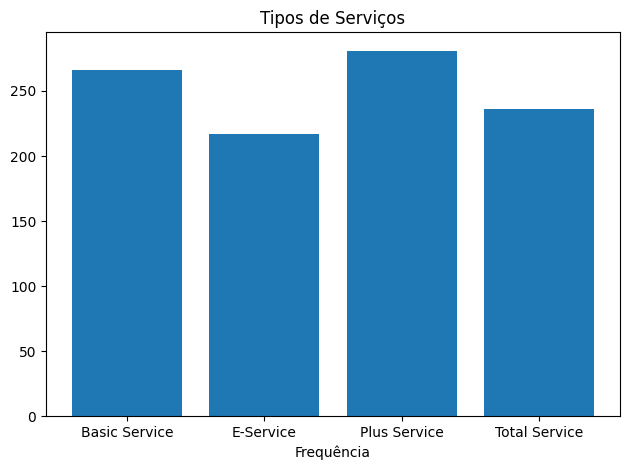

In [ ]:
fig, ax = plt.subplots()

ax.bar(x = range(1, 5), height = target_count.values)

ax.set_xticks(ticks = [1, 2, 3, 4], labels = ['Basic Service', 'E-Service', 'Plus Service', 'Total Service'])
ax.set_title('Tipos de Serviços')
ax.set_xlabel('Frequência')



fig.tight_layout()
fig.show()

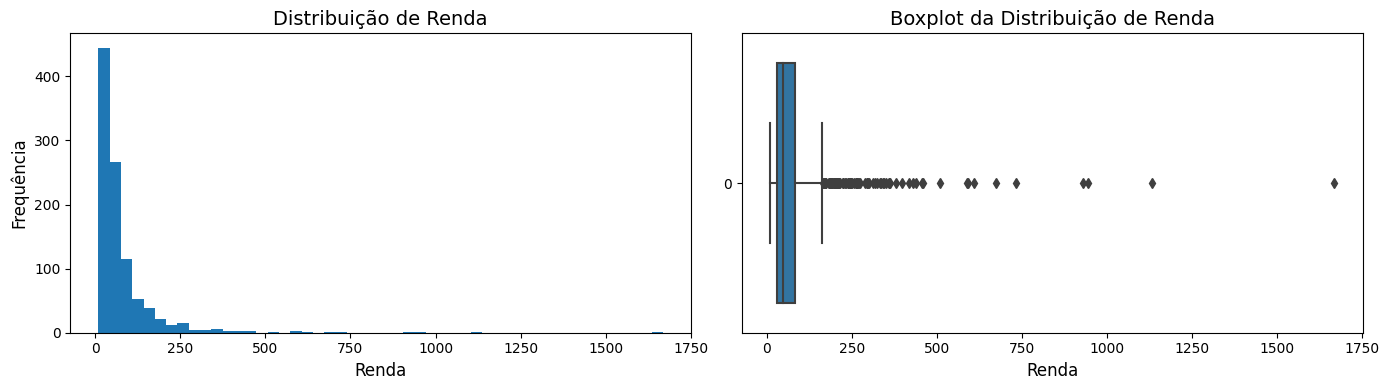

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))

ax[0].hist(df['income'], bins = 50)
sns.boxplot(df['income'], ax = ax[1], orient = 'h')

ax[0].set_title('Distribuição de Renda', fontsize = 14)
ax[0].set_xlabel('Renda', fontsize = 12)
ax[0].set_ylabel('Frequência', fontsize = 12)

ax[1].set_title('Boxplot da Distribuição de Renda', fontsize = 14)
ax[1].set_xlabel('Renda', fontsize = 12)

fig.tight_layout()
fig.show()

### Tratando os Outliers para a Variável `Income`

In [ ]:
df['income'].describe()

count    1000.000000
mean       77.535000
std       107.044165
min         9.000000
25%        29.000000
50%        47.000000
75%        83.000000
max      1668.000000
Name: income, dtype: float64

In [ ]:
# Calculando o IQR
IQR = df['income'].quantile(.75) - df['income'].quantile(.25)

print(f'A amplitude entre quartis para a variável income é {IQR}')

A amplitude entre quartis para a variável income é 54.0


In [ ]:
# Definindo limites inferior e superior: sup = Q3 + 3 x IQR e inf = Q1 - 3 x IQR
sup = df['income'].quantile(.75) + 3 * IQR
inf = df['income'].quantile(.25) - 3 * IQR

print(f'Limite superior: {sup}',
      f'\nLimite inferior: {inf}')

Limite superior: 245.0 
Limite inferior: -133.0


In [ ]:
data_income = df['income'].loc[df['income'] <= 245.0]

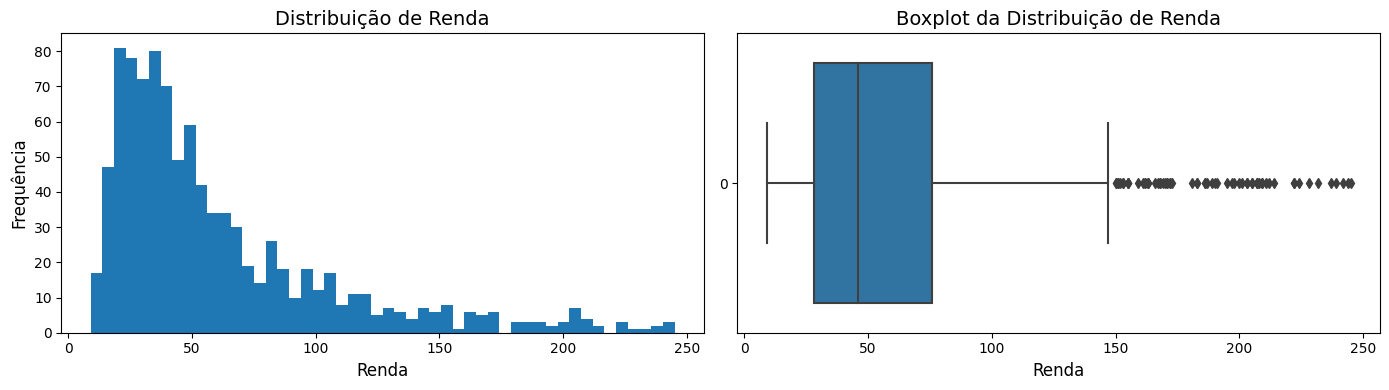

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))

ax[0].hist(data_income, bins = 50)
sns.boxplot(data_income, orient = 'h', ax = ax[1])

ax[0].set_title('Distribuição de Renda', fontsize = 14)
ax[0].set_xlabel('Renda', fontsize = 12)
ax[0].set_ylabel('Frequência', fontsize = 12)

ax[1].set_title('Boxplot da Distribuição de Renda', fontsize = 14)
ax[1].set_xlabel('Renda', fontsize = 12)

fig.tight_layout()
fig.show()

## Construção do Modelo de Classificação

### K-Nearest Neighbours

Para a construção do classificador, iremos utilizar o algoritmo de aprendizado supervisionado K-Nearest Neighbours (KNN). O KNN classifica novos exemplos baseando-se nas classes dos exemplos vizinhos. Para isso, é utilizado o cálculo de distância de Minkowski, que é basicamente a distância euclidiana, definida por:

$$ d(x, y) = \sqrt{\sum_{i = 1}^n|x_i - y_i|^2} $$

A equação acima define a distância entre o conjunto de pontos $x_i$ e $y_i$.

Além do cálculo da distância, a escolha da nova classe é definida de acordo com a similaridade dos K vizinhos mais próximos do novo exemplo. Assim, se definimos um modelo 5-NN, significa que iremos fazer o cálculo de distância dos 5 vizinhos mais próximos do novo exemplo que queremos classificar.

- **Definindo a matriz de atributos e o alvo**

In [ ]:
X = df.drop('custcat', axis = 1)
y = df['custcat']

- **Padronização dos Dados**

Em algoritmos baseados em distância, é importante se atentar à padronização dos dados. Vamos utilizar o `StandardScaler` que transforma os dados, de modo que eles tenham média zero e desvio-padrão unitário.

In [ ]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

X = std.fit_transform(X)

array([[-0.02696767, -1.055125  ,  0.18450456, ..., -0.22207644,
        -1.03459817, -0.23065004],
       [ 1.19883553, -1.14880563, -0.69181243, ..., -0.22207644,
        -1.03459817,  2.55666158],
       [ 1.19883553,  1.52109247,  0.82182601, ..., -0.22207644,
         0.96655883, -0.23065004],
       ...,
       [ 1.19883553,  1.47425216,  1.37948227, ..., -0.22207644,
         0.96655883, -0.92747794],
       [ 1.19883553,  1.61477311,  0.58283046, ..., -0.22207644,
         0.96655883, -0.92747794],
       [ 1.19883553,  0.67796676, -0.45281689, ..., -0.22207644,
         0.96655883,  0.46617787]])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

print('Dimensões dos conjuntos de treino e teste:',
      f'\nTreino:\t {X_train.shape, y_train.shape}',
      f'\nTeste:\t {X_test.shape, y_test.shape}')

Dimensões dos conjuntos de treino e teste: 
Treino:	 ((800, 11), (800,)) 
Teste:	 ((200, 11), (200,))


### Classificação

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

- **Escolhendo o valor mais apropriado de K**

In [ ]:
ks = range(1, 11)

mean = []
std = []

for k in ks:

  knn = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
  score = cross_val_score(knn, X_train, y_train, scoring = 'accuracy', cv = 10)
  mean.append(score.mean())
  std.append(score.std())

print(mean)

[0.28125, 0.28125, 0.2775, 0.31625, 0.30625, 0.3012499999999999, 0.3225, 0.31, 0.31625000000000003, 0.31875]


In [ ]:
index = mean.index(max(mean))

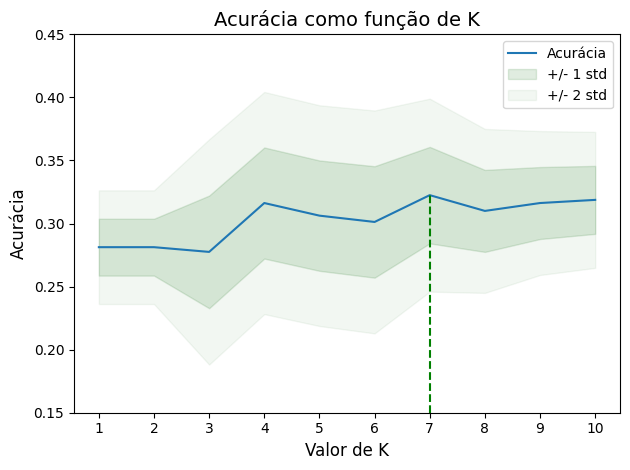

In [ ]:
fig, ax = plt.subplots()

x_range = np.arange(1, 11, 1)

ax.plot(x_range, mean, label = 'Acurácia')
ax.vlines(x = index + 1, ymin = .15, ymax = max(mean), colors = 'green', linestyles = 'dashed')
ax.fill_between(x_range, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color = 'darkgreen', alpha = .12, label = '+/- 1 std')
ax.fill_between(x_range, np.array(mean) - 2 * np.array(std), np.array(mean) + 2 * np.array(std), color = 'darkgreen', alpha = .05, label = '+/- 2 std')

ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax.set_title('Acurácia como função de K', fontsize = 14)
ax.set_xlabel('Valor de K', fontsize = 12)
ax.set_ylabel('Acurácia', fontsize = 12)
ax.set_ylim(0.15, 0.45)
ax.legend()

fig.tight_layout()
fig.show()

### Previsões

Agora que definimos o K correspondente à melhor acurácia, iremos construir o modelo final.

In [ ]:
# Instanciando o modelo
knn_final = KNeighborsClassifier(n_neighbors = 7, weights = 'distance')

# Ajustando o modelo
knn_final.fit(X_train, y_train)

# Realizando as previsões
y_pred = knn_final.predict(X_test)

- **Métricas**

In [ ]:
print(f'Acurácia no Teste: {accuracy_score(y_test, y_pred):.3f}')

Acurácia no Teste: 0.380
